In [4]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from grating import *

In [5]:
%config IPCompleter.use_jedi = False

In [6]:
epsilon_Si = 13.491
epsilon_SiO2 = 2.085136
n_freqs = 200
freqs = np.linspace(0.15, 0.25, n_freqs)
n_grating_layers = 15

In [7]:
fname = 'dataset.npz'
with np.load(fname) as data:
    designs = data['D']
    responses = data['R']
    
n_grating_layers = designs.shape[-1]
n_freqs = responses.shape[-1]
Dtrain, Dtest, Rtrain, Rtest = train_test_split(designs, responses,
                                                test_size=0.1,
                                                random_state=42)
print("Train set contains {} samples".format(Dtrain.shape[0]))
print("Validation set contains {} samples".format(Dtest.shape[0]))

Train set contains 588429 samples
Validation set contains 65381 samples


In [19]:
load_dir = 'forward_model'
fmodel = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs400_Adam0001_Sigmoid.h5'))

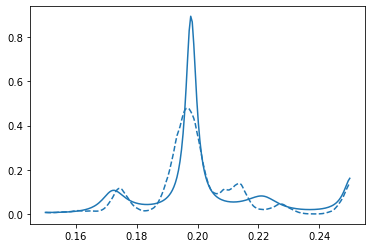

In [20]:
np.random.seed(42)
D = np.random.random_sample((1, n_grating_layers))
gr = Grating(epsilon_Si, epsilon_SiO2, D[0])
fig, ax = plt.subplots()
line, = ax.plot(freqs, gr.transmittivity(freqs))
ax.plot(freqs, fmodel(D)[0].numpy(), '--', color=line.get_color())

In [21]:
activation = keras.activations.sigmoid
inputs = layers.Input((n_freqs,), name='R')
I1 = layers.Dense(500, activation=activation, name='I1')
I2 = layers.Dense(200, activation=activation, name='I2')
I3 = layers.Dense(n_grating_layers, activation='relu', name='D')
imodel = keras.Sequential([inputs, I1, I2, I3], name='InverseNet')
imodel.summary()

Model: "InverseNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I1 (Dense)                   (None, 500)               100500    
_________________________________________________________________
I2 (Dense)                   (None, 200)               100200    
_________________________________________________________________
D (Dense)                    (None, 15)                3015      
Total params: 203,715
Trainable params: 203,715
Non-trainable params: 0
_________________________________________________________________


In [22]:
tandem = keras.Model(inputs, fmodel(imodel(inputs)),
                    name='TandemNet')
tandem.layers[-1].trainable = False
tandem.summary()

Model: "TandemNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
R (InputLayer)               [(None, 200)]             0         
_________________________________________________________________
InverseNet (Sequential)      (None, 15)                203715    
_________________________________________________________________
sequential_4 (Sequential)    (None, 200)               228800    
Total params: 432,515
Trainable params: 203,715
Non-trainable params: 228,800
_________________________________________________________________


In [27]:
def loss(y_true, y_pred):
    return n_freqs * keras.losses.mse(y_true, y_pred)

tandem.compile(loss=loss, optimizer='adam')

In [30]:
try:
    initial_epoch = tandem.history.history.epoch[-1]
except AttributeError:
    initial_epoch = 0

info = tandem.fit(Rtrain, Rtrain,
                 batch_size=128, epochs=10,
                 validation_data=(Rtest, Rtest),
                 validation_freq=1,
                 initial_epoch=initial_epoch)

Epoch 1/10
4598/4598 [==============================] - 25s 5ms/step - loss: 6.9307 - val_loss: 6.2413
Epoch 2/10
4598/4598 [==============================] - 24s 5ms/step - loss: 5.9235 - val_loss: 5.6333
Epoch 3/10
4598/4598 [==============================] - 24s 5ms/step - loss: 5.3872 - val_loss: 5.1036
Epoch 4/10
4598/4598 [==============================] - 24s 5ms/step - loss: 4.9719 - val_loss: 4.8123
Epoch 5/10
4598/4598 [==============================] - 24s 5ms/step - loss: 4.7109 - val_loss: 4.6351
Epoch 6/10
4598/4598 [==============================] - 25s 5ms/step - loss: 4.5674 - val_loss: 4.5321
Epoch 7/10
4598/4598 [==============================] - 25s 5ms/step - loss: 4.4758 - val_loss: 4.4574
Epoch 8/10
4598/4598 [==============================] - 25s 5ms/step - loss: 4.3934 - val_loss: 4.4660
Epoch 9/10
4598/4598 [==============================] - 25s 5ms/step - loss: 4.3317 - val_loss: 4.2511
Epoch 10/10
4598/4598 [==============================] - 25s 5ms/step - l

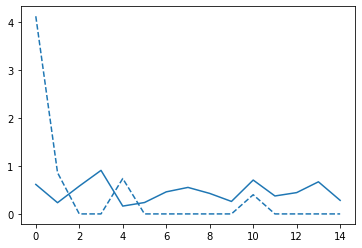

In [59]:
idx = np.random.randint(0, Rtest.shape[0], 1)
dnn_designs = imodel(Rtest[idx]).numpy()
true_designs = Dtest[idx]
for o, r in zip(dnn_designs, true_designs):
    line, = plt.plot(o, '--')
    plt.plot(r, '-', color=line.get_color())